### cos 함수를 이용하여 데이터 만들기

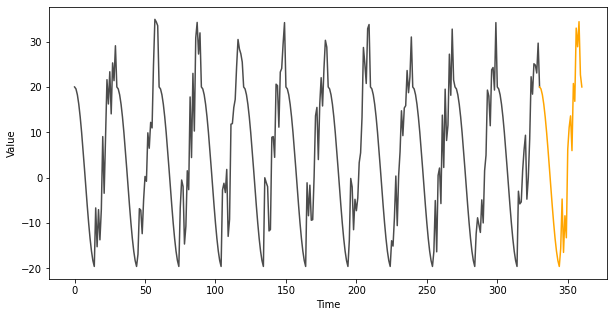

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2020)

time = np.arange(30 * 12 + 1)
month_time = (time % 30) / 30
time_series = 20 * np.where(month_time < 0.5,
                            np.cos(2 * np.pi * month_time),
                            np.cos(2 * np.pi * month_time) + np.random.random(361))
plt.figure(figsize = (10, 5))
plt.xlabel('Time')
plt.ylabel('Value')
# 학습용 데이터
plt.plot(np.arange(0, 30 * 11 + 1),
                    time_series[:30 * 11 + 1],
                    color = 'black', alpha = 0.7)
# 테스트용 데이터
plt.plot(np.arange(30 * 11, 30 * 12 + 1),
                    time_series[30 * 11:],
                    color = 'orange')

### 전처리 과정 수행하기

In [4]:
def make_sequence(time_series, n):
    x_train, y_train = list(), list()

    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break
    
    return np.array(x_train), np.array(y_train)

n = 10
x_train, y_train = make_sequence(time_series, n)

x_train = x_train.reshape(-1, n, 1)
y_train = y_train.reshape(-1, 1)

from sklearn.model_selection import train_test_split

patial_x_train = x_train[:30 * 11]
patial_y_train = y_train[:30 * 11]
x_test = x_train[30 * 11:]
y_test = y_train[30 * 11:]

print('train:', patial_x_train.shape, patial_y_train.shape)
print('test',x_test.shape, y_test.shape)


train: (330, 10, 1) (330, 1)
test (21, 10, 1) (21, 1)


### 데이터 형태 확인하기

In [6]:
test_arr = np.arange(100)
a, b = make_sequence(test_arr, 10)

for i in range(1, 4):
    print(a[i],'|', b[i])

[ 1  2  3  4  5  6  7  8  9 10] | 11
[ 2  3  4  5  6  7  8  9 10 11] | 12
[ 3  4  5  6  7  8  9 10 11 12] | 13


### SimpleRNN을 사용하여 모델 구성하기

In [7]:
from tensorflow.keras.layers import SimpleRNN, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential()
# SimpleRNN층을 첫 번째 층으로 사용하는 경우,
# 반드시 input_shape을 명사해주어야 함
model.add(SimpleRNN(units = 32, activation = 'tanh', input_shape = (n, 1)))
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


2022-06-13 03:13:16.717425: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 모델 학습하고 평가하기

In [8]:
model.fit(x_train, y_train, epochs = 100, batch_size= 12)

Epoch 1/100
30/30 [==============================] - 1s 3ms/step - loss: 239.7684
Epoch 2/100
30/30 [==============================] - 0s 3ms/step - loss: 196.2237
Epoch 3/100
30/30 [==============================] - 0s 3ms/step - loss: 165.5648
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 142.8409
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 125.1083
Epoch 6/100
30/30 [==============================] - 0s 3ms/step - loss: 111.9799
Epoch 7/100
30/30 [==============================] - 0s 3ms/step - loss: 100.9400
Epoch 8/100
30/30 [==============================] - 0s 3ms/step - loss: 93.4452
Epoch 9/100
30/30 [==============================] - 0s 3ms/step - loss: 87.6498
Epoch 10/100
30/30 [==============================] - 0s 3ms/step - loss: 82.4359
Epoch 11/100
30/30 [==============================] - 0s 3ms/step - loss: 78.1532
Epoch 12/100
30/30 [==============================] - 0s 3ms/step - loss: 74.3150
Epoch 13/100
30/30

### 예측 결과 그려보기

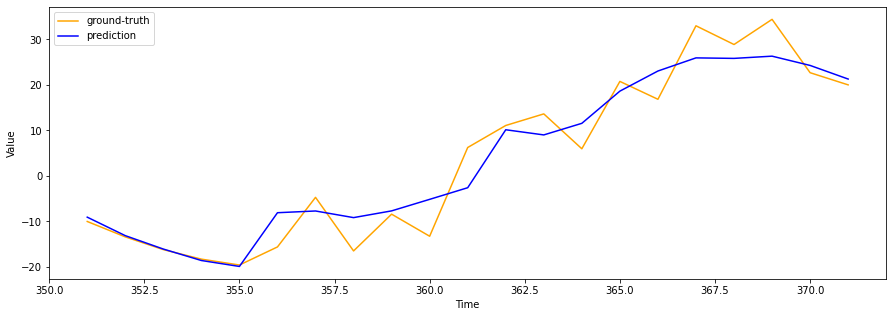

In [9]:
pred = model.predict(x_test)

pred_range = np.arange(len(y_train), len(y_train) + len(pred))

plt.figure(figsize=(15,5))
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color = 'orange', label='ground-truth')
plt.plot(pred_range, pred.reshape(-1,), color = 'blue', label='prediction')
plt.legend()
plt.show()

### IMDB 데이터셋 사용하기

In [10]:
from tensorflow.keras.datasets import imdb

num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 500

pad_X_train = pad_sequences(X_train, maxlen = max_len)
pad_X_test = pad_sequences(X_test, maxlen = max_len)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding

In [12]:
model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 32))
# 새로운 인자 세 개가 사용됨
model.add(SimpleRNN(32, return_sequences=True, dropout=0.15, recurrent_dropout=0.15))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
            loss = 'binary_crossentropy',
            metrics = ['acc']
)

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          320000    
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, None, 32)          2080      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 324,193
Trainable params: 324,193
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(pad_X_train, y_train,
                    batch_size = 32, epochs = 15,
                    validation_split = 0.2)

Epoch 1/15
625/625 [==============================] - 104s 165ms/step - loss: 0.6961 - acc: 0.5124 - val_loss: 0.6827 - val_acc: 0.5478
Epoch 2/15
625/625 [==============================] - 101s 162ms/step - loss: 0.6398 - acc: 0.6267 - val_loss: 0.6142 - val_acc: 0.6476
Epoch 3/15
224/625 [=========>....................] - ETA: 1:16 - loss: 0.5876 - acc: 0.6998